In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import os
import time
import copy
import pickle
import random
from random import shuffle 
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
# from keras.utils.np_utils import to_categorical
from gensim.models import Word2Vec
from multiprocessing import cpu_count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
# from torchtext.data import Example
# import torchtext

torch.manual_seed(10)


%load_ext autoreload
%autoreload 2
this = sys.modules[__name__]

In [0]:
# !tar -xvzf ./data/cnn_stories.tgz -C ./data/cnn_data/
# !rm ./data/cnn_stories.tgz
# !rm -r ./data/cnn_data/

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
# from model import lstm
# os.chdir(curDir+'/data')
import reader # reader.py

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


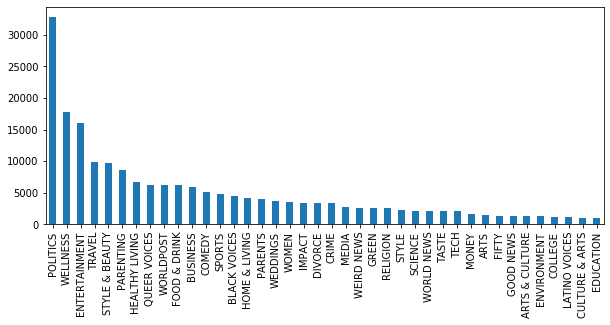

In [0]:
df = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)
#data = df.iloc[:,1:4].drop(columns='date')
df = df.sample(frac=1,random_state=4).reset_index(drop=True)

#print(cates.size())
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

#cates = df.groupby('category')
#print("total categories:", cates.ngroups)

#df_temp = df.copy().drop(columns=['category','headline'])
df = df.iloc[:,:2]#.drop(columns=['date'])
df.head(5)
my_tags= list(set(df.category.values))
plt.figure(figsize=(10,4))
df.category.value_counts().plot(kind='bar');


In [0]:
def read_numpy_files():
    """Instead of running the entire pipeline at all times."""
    filename = os.path.join(curDir, 'data', 'train_test_data.dat') ##@
    with open(filename, 'rb') as handle:
        x_train = pickle.load(handle)
        y_train = pickle.load(handle)
        x_test = pickle.load(handle)
        y_test = pickle.load(handle)
        int_category = pickle.load(handle)
        category_int = pickle.load(handle)

    return (x_train, y_train), (x_test, y_test), int_category, category_int

def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
if __name__ == "__main__":
    document_max_num_words = 15
    num_features = 300
    firstTime = False
    cache = True
    reuters = False
    reader.generate_categories(reuters)
    class_names = reader.categories ##@
    print('reading data...')
    # TODO: Fix the big the cache mechanism ##@ Done
    if (cache):
        (x_train, y_train), (x_test, y_test), int_category, category_int = read_numpy_files()
    else:
        (x_train, y_train), (x_test, y_test), int_category, category_int = reader.prepare_data()

    #(x_train, y_train), (x_test, y_test) = reader.read_retuters_files()
    #(x_train, y_train), (x_test, y_test), int_category, category_int = reader.prepare_data()
    
    if firstTime:
        
        print('tokenizing training docs...')
        x_train = reader.tokenize_docs(x_train)
        
        print('tokenizing testing docs...')
        x_test = reader.tokenize_docs(x_test)
        
        w2v_model = Word2Vec(x_train + x_test,
                             size=num_features,
                             min_count=1,
                             window=10,
                             workers=cpu_count())
        w2v_model.init_sims(replace=True)
        w2v_model.save('./model/reuters_train.word2vec')
        
        print('vectorizing training docs...')
        x_train = reader.vectorize_docs(x_train, w2v_model, document_max_num_words, num_features)
        y_train = reader.vectorize_categories(y_train)
        
        #w2v_model = Word2Vec(x_test,
        #                     size=num_features,
        #                     min_count=1,
        #                     window=10,
        #                     workers=cpu_count())
        #
        #w2v_model.init_sims(replace=True)
        #w2v_model.save('./model/reuters_test.word2vec')
        
        print('vectorizing testing docs...')
        x_test = reader.vectorize_docs(x_test, w2v_model, document_max_num_words, num_features)
        y_test = reader.vectorize_categories(y_test)
        
        # save vectorized form
        np.savez_compressed(os.path.join('data', 'vectorized_data.npz'),
                            a=x_train, b=y_train, c=x_test, d=y_test)
        
    else:
        with np.load(os.path.join('data', 'vectorized_data.npz')) as d:
            x_train =   d['a']
            y_train =   d['b']
            x_test =    d['c']
            y_test =    d['d']
            
    print('building lstm model...')
#     lstm.lstm(x_train, y_train, x_test, y_test, int_category, document_max_num_words, num_features)


reading data...
building lstm model...


In [0]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(int_category)
print(class_names)

(160682, 15, 300) (160682, 40)
(40171, 15, 300) (40171, 40)
{0: 'ARTS', 1: 'ARTS & CULTURE', 2: 'BLACK VOICES', 3: 'BUSINESS', 4: 'COLLEGE', 5: 'COMEDY', 6: 'CRIME', 7: 'CULTURE & ARTS', 8: 'DIVORCE', 9: 'EDUCATION', 10: 'ENTERTAINMENT', 11: 'ENVIRONMENT', 12: 'FIFTY', 13: 'FOOD & DRINK', 14: 'GOOD NEWS', 15: 'GREEN', 16: 'HEALTHY LIVING', 17: 'HOME & LIVING', 18: 'IMPACT', 19: 'LATINO VOICES', 20: 'MEDIA', 21: 'MONEY', 22: 'PARENTING', 23: 'PARENTS', 24: 'POLITICS', 25: 'QUEER VOICES', 26: 'RELIGION', 27: 'SCIENCE', 28: 'SPORTS', 29: 'STYLE', 30: 'STYLE & BEAUTY', 31: 'TASTE', 32: 'TECH', 33: 'TRAVEL', 34: 'WEDDINGS', 35: 'WEIRD NEWS', 36: 'WELLNESS', 37: 'WOMEN', 38: 'WORLD NEWS', 39: 'WORLDPOST'}
['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'CULTURE & ARTS' 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT'
 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK' 'GOOD NEWS' 'GREEN' 'HEALTHY LIVING'
 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'MONEY' 'PARENTING'
 'PARENTS' '

In [0]:
y = np.concatenate((y_train, y_test))
unique, counts = np.unique(y, return_counts=True,axis=0)
print(dict(zip(unique.argmax(1), counts)))
states = counts[::-1]/len(y)
# pos_weight=np.copy(states)
# pos_weight[np.where(pos_weight<0.01)]=5
# pos_weight[np.where(pos_weight<0.02)]=2
# pos_weight[np.where(pos_weight<0.05)]=1
# pos_weight[np.where(pos_weight<0.16)]=0.5
# pos_weight[np.where(states>=0.16)]=0.25
pos_weight=states.min()/states*5
print(pos_weight)

{39: 6243, 38: 2177, 37: 3490, 36: 17827, 35: 2670, 34: 3651, 33: 9887, 32: 2082, 31: 2096, 30: 9649, 29: 2254, 28: 4884, 27: 2178, 26: 2556, 25: 6314, 24: 32739, 23: 3955, 22: 8677, 21: 1707, 20: 2815, 19: 1129, 18: 3459, 17: 4195, 16: 6694, 15: 2622, 14: 1398, 13: 6226, 12: 1401, 11: 1323, 10: 16058, 9: 1004, 8: 3426, 7: 1030, 6: 3405, 5: 5175, 4: 1144, 3: 5937, 2: 4528, 1: 1339, 0: 1509}
[3.32670643 3.74906647 1.10865724 0.84554489 4.38811189 0.97004831
 1.4743025  4.87378641 1.46526562 5.         0.31261676 3.79440665
 3.58315489 0.80629618 3.59084406 1.91456903 0.74992531 1.19666269
 1.4512865  4.44641275 1.78330373 2.94083187 0.57854097 1.26927939
 0.15333394 0.7950586  1.96400626 2.30486685 1.02784603 2.22715173
 0.52026117 2.39503817 2.41114313 0.50773743 1.37496576 1.88014981
 0.28159533 1.43839542 2.30592559 0.80410059]


In [0]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __getitem__(self,index):
        data,target = self.dataset[index]
        return data,target,index
    def __len__(self):
        return len(self.dataset)

In [0]:
num_categories = len(int_category)
batch_size=256 
n_lr = 1e-2
decay = 1e-7
n_epochs = 50
lstm_out = [128,64,32]
dense_layer = 64
SEED = 10
n_splits = 7

In [0]:
class LSTMTopic(nn.Module):
    def __init__(self, num_features, lstm_out, dense_out, num_categories, uselast=True, maxpool=False):
        super(LSTMTopic, self).__init__()
        self.hidden_dim = lstm_out[1]
        self.uselast = uselast
        self.maxpool = maxpool
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm1 = nn.LSTM(num_features, self.hidden_dim, 2, batch_first=True, dropout=0.5)
        self.lstm2 = nn.LSTM(num_features, self.hidden_dim , 1, batch_first=True)
        # The linear layer that maps from hidden state space to tag space
        # self.dense= nn.Linear(self.hidden_dim , dense_out)
        # self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.hidden_dim , num_categories)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        x, (h, c) = self.lstm1(inputs)
        #x, _ = nn.utils.rnn.pad_packed_sequence(x)
        x = self.drop(x)
        # x, _ = self.lstm2(x)
        # x, _ = self.lstm3(x)
        if self.uselast:
            x = x[:,-1].view(len(x), -1)
        elif self.maxpool:
            x = torch.transpose(x, 1, 2)#torch.Size([batch, hidden, seq])
            x = torch.tanh(x)
            x, indices = F.max_pool1d(x,x.size(2), return_indices=True)
            x = torch.tanh(x)
            x = x.squeeze(2)
        else:
            x = torch.mean(x, dim=1)
        # x = self.relu(self.dense(x))
        # x = self.drop(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

In [0]:
def pytorch_model_run_cv(x_train,y_train,features,x_test, y_test, model_obj, Cats, pos_weight, feats = False,clip = True):
    seed_everything()
    avg_losses_f = []
    avg_val_losses_f = []
    avg_accs_f = []
    avg_val_accs_f = []
    pos_weight = torch.tensor(pos_weight, dtype=torch.float32).cuda()
    # matrix for the out-of-fold predictions
    train_preds = np.zeros((len(x_train),Cats))
    # matrix for the predictions on the test set
    test_preds = np.zeros((len(x_test), Cats))
    splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(x_train, y_train[:,1])
    x_test = torch.tensor(x_test, dtype=torch.float32).cuda()
    y_test = torch.tensor(y_test, dtype=torch.float32).cuda()
    test = MyDataset(torch.utils.data.TensorDataset(x_test, y_test))
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    for i, (train_idx, valid_idx) in enumerate(splits):
        seed_everything(i*1000+i)
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        if feats:
            features = np.array(features)
        x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.float32).cuda()
        y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
        if feats:
            kfold_X_features = features[train_idx.astype(int)]
            kfold_X_valid_features = features[valid_idx.astype(int)]
        x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.float32).cuda()
        y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()

        model = copy.deepcopy(model_obj)

        model.cuda()
        
        loss_fn = nn.BCELoss()#(reduction='sum')
        # loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        step_size = 300
        base_lr, max_lr = n_lr/5, n_lr   
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                 lr=max_lr)

        ################################################################################################
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                   step_size_up=step_size, mode='exp_range',
                   gamma=0.99994, cycle_momentum=False)
        ###############################################################################################
        #print('xtrain',X_train[0])
        #print('xtrainF',x_train_fold[0])

        train = MyDataset(torch.utils.data.TensorDataset(x_train_fold, y_train_fold))
        #print('train',train[0])
        valid = MyDataset(torch.utils.data.TensorDataset(x_val_fold, y_val_fold))

        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        #print('loader',train_loader[0])
        valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

        print(f'Fold {i + 1}')
        for epoch in range(n_epochs):
            start_time = time.time()
            model.train()

            avg_loss = 0.  
            avg_acc = 0.
            for i, (x_batch, y_batch, index) in enumerate(train_loader):
                y_batch = y_batch.view(len(y_batch), -1)
                if feats:       
                    f = kfold_X_features[index]
                    y_pred = model([x_batch,f])
                else:
                    y_pred = model(x_batch)

                
                # Compute and print loss.
                #print(y_pred.shape, y_batch.shape)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(),1)
                optimizer.step()
                if scheduler:
                    scheduler.step()

                avg_loss += loss.item() / len(train_loader)
                acc =(y_pred.argmax(dim=1)==y_batch.argmax(dim=1)).sum().cpu().numpy()/len(y_pred)
                avg_acc += acc / len(train_loader)
            #avg_loss /= i+1
            #avg_acc /= i+1
                

            model.eval()

            valid_preds_fold = np.zeros((x_val_fold.size(0), Cats))
            test_preds_fold = np.zeros((len(x_test), Cats))

            avg_val_loss = 0.
            avg_val_acc = 0.
            for i, (x_batch, y_batch, index) in enumerate(valid_loader):
                y_batch = y_batch.view(len(y_batch), -1)
                if feats:
                    f = kfold_X_valid_features[index]            
                    y_pred = model([x_batch,f]).detach()
                else:
                    y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                val_acc =(y_pred.argmax(dim=1)==y_batch.argmax(dim=1)).sum().cpu().numpy()/len(y_pred)
                avg_val_acc += val_acc / len(valid_loader)
                valid_preds_fold[index] = y_pred.cpu().numpy()#[:, 0]
            #avg_val_loss /= i+1
            #avg_val_acc /= i+1

            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t loss={:.4f} \t acc={:.4f} \t val_loss={:.4f} \t avg_val_acc={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_acc, avg_val_loss, avg_val_acc, elapsed_time))
            avg_losses_f.append(avg_loss)
            avg_val_losses_f.append(avg_val_loss) 
            avg_accs_f.append(avg_acc)
            avg_val_accs_f.append(avg_val_acc) 
        
        # predict all samples in the test set batch per batch
        for i, (x_batch, y_batch, index) in enumerate(test_loader):
            if feats:
                f = test_features[i * batch_size:(i+1) * batch_size]
                y_pred = model([x_batch,f]).detach()
            else:
                y_pred = model(x_batch).detach()

            test_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()#[:, 0]

        train_preds[valid_idx] = valid_preds_fold
        test_preds += test_preds_fold / n_splits
        break
    print('All \t loss={:.4f} \t acc={:.4f} \t val_loss={:.4f} \t avg_val_acc={:.4f} \t '
          .format(np.average(avg_losses_f),np.average(avg_accs_f),np.average(avg_val_losses_f),np.average(avg_val_accs_f)))
    return model, train_preds, test_preds, avg_losses_f, avg_val_losses_f

In [0]:
beg = time.time()
model_obj = LSTMTopic(num_features, lstm_out, dense_layer, num_categories,False)
# model_obj.load_state_dict(torch.load(os.path.join(curDir,'ModelData','Pytorch_Model','model_state_dict.pth')))
model, train_preds, test_preds, avg_losses_f, avg_val_losses_f = pytorch_model_run_cv(x_train,y_train,0,x_test,y_test, model_obj, num_categories, pos_weight, feats = False,clip = True)
print("Training time = %.2fs"%(time.time()-beg))

Fold 1
Epoch 1/50 	 loss=0.0798 	 acc=0.3828 	 val_loss=0.0680 	 avg_val_acc=0.4710 	 time=8.19s
Epoch 2/50 	 loss=0.0671 	 acc=0.4824 	 val_loss=0.0641 	 avg_val_acc=0.5017 	 time=7.89s
Epoch 3/50 	 loss=0.0640 	 acc=0.5055 	 val_loss=0.0631 	 avg_val_acc=0.5099 	 time=8.17s
Epoch 4/50 	 loss=0.0622 	 acc=0.5180 	 val_loss=0.0624 	 avg_val_acc=0.5160 	 time=7.86s
Epoch 5/50 	 loss=0.0611 	 acc=0.5262 	 val_loss=0.0612 	 avg_val_acc=0.5225 	 time=8.12s
Epoch 6/50 	 loss=0.0604 	 acc=0.5310 	 val_loss=0.0602 	 avg_val_acc=0.5287 	 time=8.05s
Epoch 7/50 	 loss=0.0598 	 acc=0.5356 	 val_loss=0.0600 	 avg_val_acc=0.5304 	 time=7.91s
Epoch 8/50 	 loss=0.0591 	 acc=0.5410 	 val_loss=0.0592 	 avg_val_acc=0.5378 	 time=8.02s
Epoch 9/50 	 loss=0.0587 	 acc=0.5433 	 val_loss=0.0588 	 avg_val_acc=0.5401 	 time=7.89s
Epoch 10/50 	 loss=0.0582 	 acc=0.5466 	 val_loss=0.0586 	 avg_val_acc=0.5400 	 time=8.13s
Epoch 11/50 	 loss=0.0576 	 acc=0.5517 	 val_loss=0.0590 	 avg_val_acc=0.5369 	 time=7.87s
E

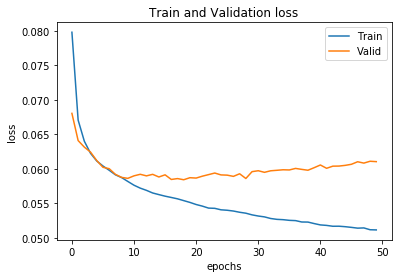

In [0]:
t = np.arange(len(avg_losses_f))
plt.figure()

plt.plot(t, avg_losses_f, label='Train')
plt.plot(t, avg_val_losses_f, label='Valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation loss')
plt.legend()
plt.show()

In [0]:
avg_losses_f

In [0]:
print('Average Train accuracy ',(train_preds.argmax(1)==y_train.argmax(1)).sum()/len(y_train))
print('Average Test accuracy ',(test_preds.argmax(1)==y_test.argmax(1)).sum()/len(y_test))

Average Train accuracy  0.08329495525323309
Average Test accuracy  0.5447213163725075


In [0]:
# x_tt = torch.tensor(x_train, dtype=torch.float32).cuda()
# y_tt = torch.tensor(y_train, dtype=torch.float32).cuda()
# y_pp = model(x_tt).detach()
# print('Predicted Train accuracy ',(y_pp.argmax(dim=1)==y_tt.argmax(dim=1)).sum().cpu().numpy()/len(y_pp))
model.cpu()
x_t = torch.tensor(x_test, dtype=torch.float32)
y_t = torch.tensor(y_test, dtype=torch.float32)
beg = time.time()
y_p = model(x_t).detach()
print('Predicted Test accuracy ',(y_p.argmax(dim=1)==y_t.argmax(dim=1)).sum().cpu().numpy()/len(y_p))
print("Prediction time = %.2fs"%(time.time()-beg))

Predicted Test accuracy  0.5447213163725075
Prediction time = 3.47s


In [0]:
print('Train statistics:')
print('accuracy %s' % accuracy_score(y_pp.argmax(dim=1).cpu(), y_tt.argmax(dim=1).cpu()))
print(classification_report(y_tt.argmax(dim=1).cpu(), y_pp.argmax(dim=1).cpu(),target_names=list(int_category.values())))
print('Test statistics:')
print('accuracy %s' % accuracy_score(y_p.argmax(dim=1).cpu(), y_t.argmax(dim=1).cpu()))
print(classification_report(y_t.argmax(dim=1).cpu(), y_p.argmax(dim=1).cpu(),target_names=list(int_category.values())))

Train statistics:
accuracy 0.6111325475162122
                precision    recall  f1-score   support

          ARTS       0.33      0.23      0.27      1245
ARTS & CULTURE       0.39      0.15      0.22      1086
  BLACK VOICES       0.51      0.42      0.46      3664
      BUSINESS       0.50      0.42      0.46      4763
       COLLEGE       0.58      0.39      0.47       915
        COMEDY       0.66      0.47      0.55      4086
         CRIME       0.59      0.57      0.58      2708
CULTURE & ARTS       0.53      0.34      0.41       867
       DIVORCE       0.71      0.71      0.71      2717
     EDUCATION       0.43      0.27      0.33       806
 ENTERTAINMENT       0.63      0.76      0.69     12818
   ENVIRONMENT       0.78      0.21      0.32      1068
         FIFTY       0.33      0.02      0.04      1125
  FOOD & DRINK       0.60      0.78      0.67      4998
     GOOD NEWS       0.41      0.30      0.35      1134
         GREEN       0.40      0.41      0.40      2082
H

# 6. Save necessary files

In [0]:
modelspath=os.path.join(curDir,'ModelData','Pytorch_Model')
if not os.path.exists(modelspath):
    os.makedirs(modelspath)
torch.save(model.state_dict(), os.path.join(modelspath,'model_state_dict_v4.pth'))
# torch.save(model, os.path.join(modelspath,'model.pth'))
print('Saved')

Saved
